# Dataset GAN

In [1]:
import os
import torch
import torch.nn as nn
from torchvision.utils import save_image
import pandas as pd
from pathlib import Path
from PIL import Image

# CONFIGURACIÓN
latent_dim = 256
n_imgs_target = 2000
class_counts = {
    "G": 260,
    "C": 292,
    "A": 242,
    "M": 238
}

# RUTA DE CHECKPOINTS PERSONALIZADOS
custom_checkpoints = {
    "G": "WGAN_ema_G_epoch_156.pth",  # ejemplo, cámbialo por el que quieras
    "C": "WGAN_ema_G_epoch_158.pth",
    "A": "WGAN_ema_G_epoch_079.pth",
    "M": "WGAN_ema_G_epoch_056.pth"
}

base_dir = Path("C:/Users/34629/TFG")
model_dir = base_dir / "wgan_gp_mio"
output_dir = base_dir / "generated_images_gan_mio"
csv_path = base_dir / "single_label_dataset_without_H_no_O.csv"
new_csv_path = base_dir / "dataset_GAN_mio.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GENERADOR DEBE SER IGUAL QUE EN EL ENTRENAMIENTO
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
        )
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return torch.relu(self.block(x) + self.skip(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ResBlock(512, 256),
            nn.Upsample(scale_factor=2),
            ResBlock(256, 128),
            nn.Upsample(scale_factor=2),
            ResBlock(128, 64),
            nn.Upsample(scale_factor=2),
            ResBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), 512, 4, 4)
        return self.model(x)

# CARGAR CSV ORIGINAL
df = pd.read_csv(csv_path)
new_entries = []

# PROCESAR CADA CLASE
for class_name, n_original in class_counts.items():
    n_to_generate = n_imgs_target - n_original
    print(f"Clase {class_name}: generando {n_to_generate} imágenes...")

    # Cargar modelo con checkpoint elegido
    gen = Generator().to(device)
    checkpoint_name = custom_checkpoints[class_name]
    model_path = model_dir / class_name / "checkpoints_wgan_gp" / checkpoint_name
    gen.load_state_dict(torch.load(model_path, map_location=device))
    gen.eval()

    # Carpeta de salida
    class_out_dir = output_dir / class_name
    class_out_dir.mkdir(parents=True, exist_ok=True)

    # Generar imágenes
    batch_size = 64
    n_batches = (n_to_generate + batch_size - 1) // batch_size
    count = 0

    for i in range(n_batches):
        cur_batch = min(batch_size, n_to_generate - count)
        z = torch.randn(cur_batch, latent_dim, device=device)
        z = z / torch.norm(z, dim=1, keepdim=True)
        with torch.no_grad():
            imgs = gen(z)

        for j in range(cur_batch):
            img_tensor = imgs[j]
            img_name = f"img_{class_name}_{count + j:04d}.png"
            img_path = class_out_dir / img_name
            save_image(img_tensor, img_path, normalize=True)

            new_row = {"Image_Path": str(img_path)}
            for col in ['N', 'D', 'G', 'C', 'A', 'M', 'O']:
                new_row[col] = 1 if col == class_name else 0
            new_entries.append(new_row)

        count += cur_batch

# AÑADIR NUEVAS FILAS Y GUARDAR CSV
df_new = pd.DataFrame(new_entries)
df_combined = pd.concat([df, df_new], ignore_index=True)
df_combined.to_csv(new_csv_path, index=False)

print("✅ Generación y guardado completo.")


Clase G: generando 1740 imágenes...
Clase C: generando 1708 imágenes...
Clase A: generando 1758 imágenes...
Clase M: generando 1762 imágenes...
✅ Generación y guardado completo.


In [2]:
import pandas as pd

# Ruta del CSV
csv_path = "C:/Users/34629/TFG/dataset_GAN_mio.csv"

# Cargar el dataset
df = pd.read_csv(csv_path)

# Reemplazar '\' por '/' en la columna de rutas
df["Image_Path"] = df["Image_Path"].apply(lambda x: x.replace("\\", "/"))

# Guardar el archivo actualizado
df.to_csv(csv_path, index=False)

print("✅ Rutas de las imágenes corregidas en 'dataset_GAN_mio.csv'.")


✅ Rutas de las imágenes corregidas en 'dataset_GAN_mio.csv'.


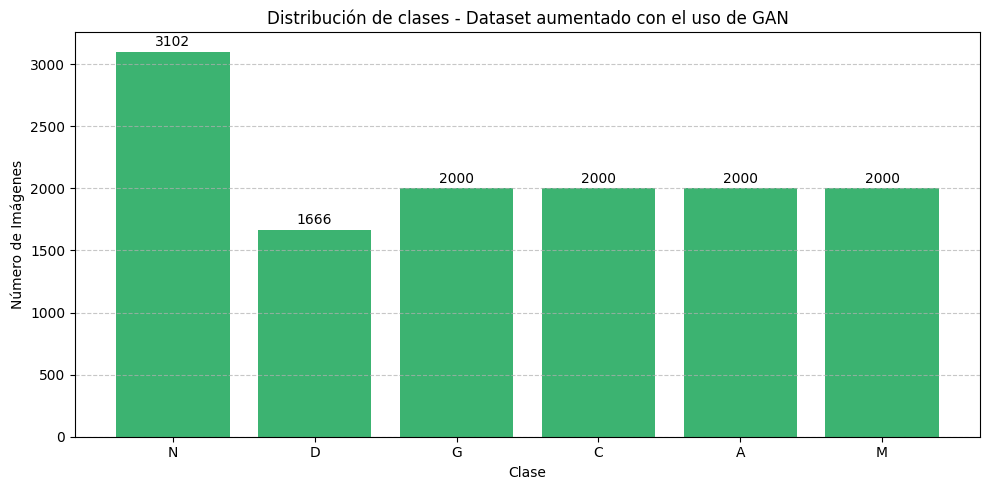

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datasets
df_augmented_filtered = pd.read_csv("C:/Users/34629/TFG/dataset_GAN_mio.csv")

# Columnas de clases
filtered_classes = ['N', 'D', 'G', 'C', 'A', 'M']

# Contar ocurrencias por clase
counts_augmented_filtered = df_augmented_filtered[filtered_classes].sum()

# Función para generar el gráfico con etiquetas sobre cada barra
def plot_distribution(counts, title, color):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(counts.index, counts.values, color=color)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 20, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)
    plt.title(title, fontsize=12)
    plt.xlabel('Clase')
    plt.ylabel('Número de Imágenes')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Dibujar los gráficos
plot_distribution(counts_augmented_filtered, 'Distribución de clases - Dataset aumentado con el uso de GAN', 'mediumseagreen')
